I searched [Kaggle's datasets](https://www.kaggle.com/datasets) using the term "customer segmentation." The datasets returned appear to be primarily concerned with retail applications and consumer behavior. In most of these datasets, observations describe individual customers (and their demographics and consumption habits) or individual transactions (and characteristics of their associated products and customers).

I selected a [Credit Card Dataset for Clustering](https://www.kaggle.com/arjunbhasin2013/ccdata) for an analysis. One reason I chose this dataset was to get more familiarity and experience using clustering methods (it was not something I focused on in previous project work with unsupervised learning) to identify different classes of observations. Another reason I chose this dataset is my interest in modeling human behavior and using data to generate insights to influence and reinforce behaviors -- and data on spending, consumption, and general personal financial habits of credit card users seems like a good introductory vehicle for that. Finally, compared to similar datasets, I felt this particular one was richer in terms of the number of observations and the number of features to make meaningful insights from a pretty basic analysis (as I am about to demonstrate).

A series of questions I wanted to address using this dataset was: what defined groups of similar users can we identify, can we define their common characteristics, and can those insights be used for future interactions with users in each particular group? Basically, I would like to see what different types of users exist for this credit card provider and how those types cluster together according to their card usage and management patterns. 

To address this problem, I will first be performing some exploratory data analysis to observe the distribution of the features across all the data and any messiness within the data, as well as to understand the context of some of the features and the relationships between them. Then, I will use K-Means clustering to identify user groups and create some visualizations to reason about the shared characteristics of users in these clusters and the potential insights to be drawn.

My workflow is documented below: notes on the work in some places are shown as comments in the code.

In [1]:
# Imports
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

In [2]:
# Read in data to df and take a look
ccdata = pd.read_csv('CC GENERAL.csv')
ccdata.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
# Check for duplicate customers, there appear to be none!
sum(ccdata['CUST_ID'].duplicated())

0

In [4]:
# Look at missing values
ccdata.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

There appear to be a fair amount of missing values for individual users for `MINIMUM_PAYMENTS`. Before deciding how to handle these and the missing value from `CREDIT LIMIT`, let's first take a look at the distributions of the features below. Granted, some of these are not binned too optimally, but what we can see is that some of these features are skewed distributionally.

Consequently, at this stage, missing values will be imputed with median feature values, although one might do otherwise seeing how many observations with missing values for `MINIMUM PAYMENTS` also have a zero under `PAYMENTS`. Additionally, the features describing monetary values will be log-transformed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12743b400>,
      dtype=object)

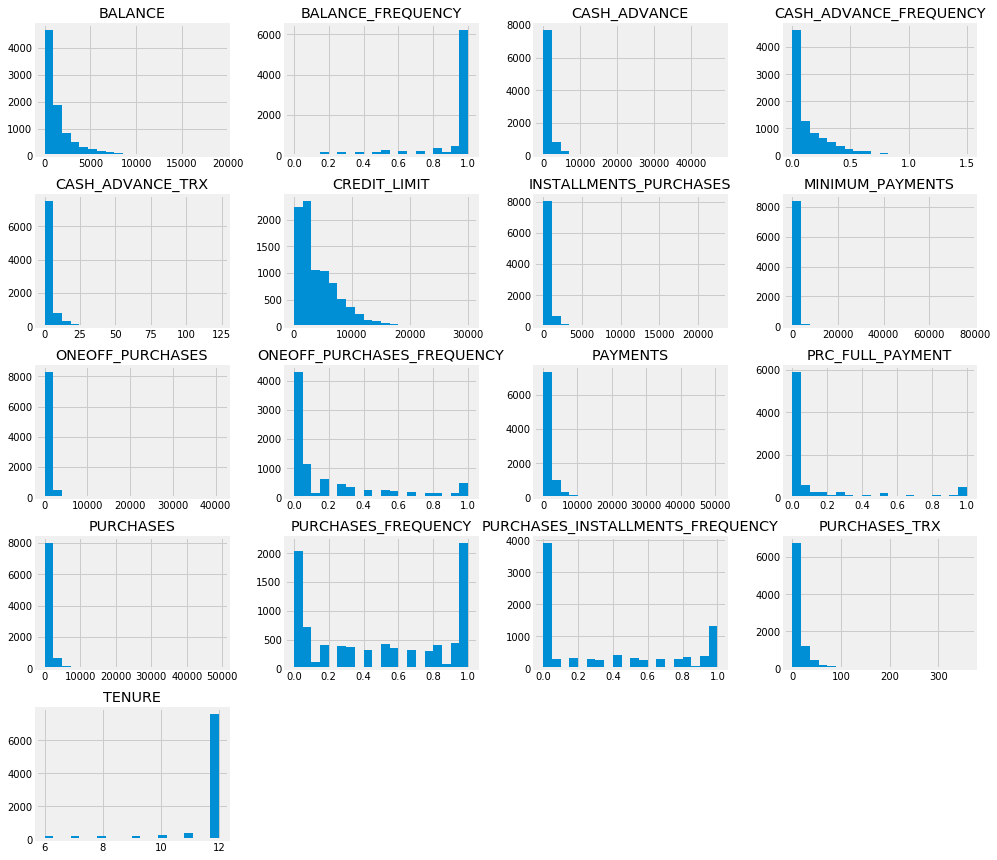

In [5]:
ccdata.hist(figsize=(15,15), bins=20)

In [6]:
# Look at rows with missing values for 'MINIMUM_PAYMENTS'
ccdata.loc[ccdata['MINIMUM_PAYMENTS'].isnull()][['PAYMENTS', 'MINIMUM_PAYMENTS']]

,PAYMENTS,MINIMUM_PAYMENTS
3,0.000000,NaN
45,0.000000,NaN
47,0.000000,NaN
54,417.016763,NaN
55,0.000000,NaN
56,0.000000,NaN
63,0.000000,NaN
93,0.000000,NaN
94,0.000000,NaN
97,0.000000,NaN


In [7]:
# Replace missing value for CREDIT_LIMIT with the median for the column
ccdata['CREDIT_LIMIT'].fillna(ccdata['CREDIT_LIMIT'].median(), inplace=True)
ccdata['MINIMUM_PAYMENTS'].fillna(ccdata['MINIMUM_PAYMENTS'].median(), inplace=True)

In [8]:
# Log transform features which are monetary values
money_cols = ['BALANCE',\
              'CASH_ADVANCE',\
              'CREDIT_LIMIT',\
              'INSTALLMENTS_PURCHASES',\
              'ONEOFF_PURCHASES',\
              'MINIMUM_PAYMENTS',\
              'PAYMENTS',\
              'PURCHASES']

In [9]:
ccdata[money_cols] = np.log(1 + ccdata[money_cols])

In [10]:
corr = ccdata.corr()

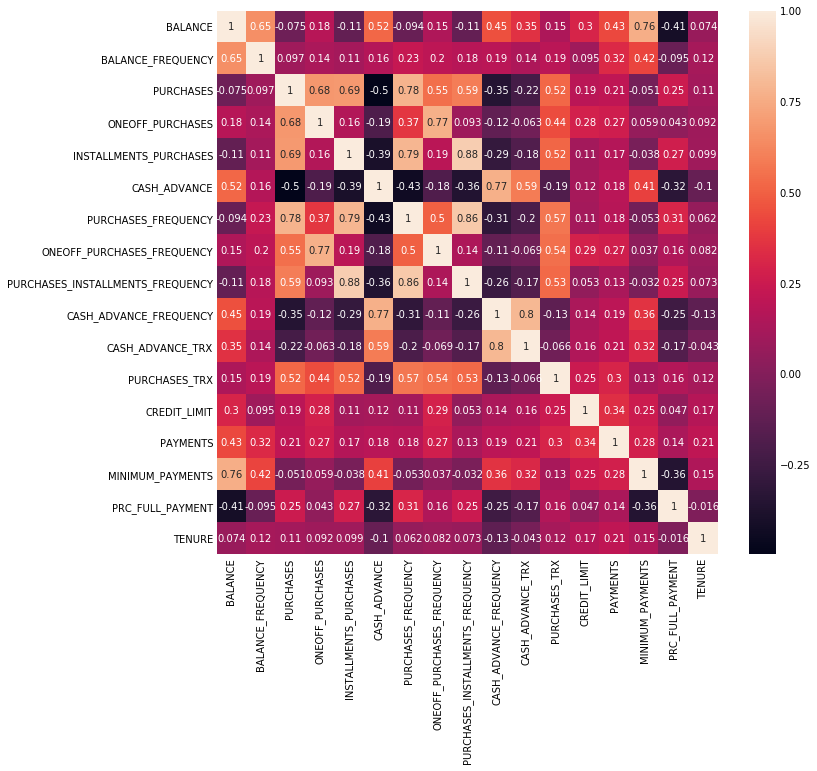

In [44]:
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)

Now to take stock of the relationships between the features, we see that the strongest correlations tend to be between features describing the different transaction types (their values/counts/frequencies), as one might expect. However, these correlations do not mean the different groups of transaction features (`PURCHASES` and `PURCHASES_FREQUENCY` for example) are redundant, nor would a redundancy mean that we can't proceed with an application of clustering.

Let's now apply K-Means clustering to the credit card user data -- first we need to scale the data, since some features are (log) dollar values, some are counts, some are frequencies restricted to [0,1] and K-Means error measurements are distance-based. Then, we estimate an "optimal" number of clusters to describe these users.

In [13]:
sc = MinMaxScaler()
scaled_ccdata = sc.fit_transform(ccdata.iloc[:, 1:])

In [14]:
inertia = []
sil = []
for k in range(2,11):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit_predict(scaled_ccdata)
    labels = km.labels_
    sil.append(metrics.silhouette_score(scaled_ccdata, labels, metric='euclidean'))
    inertia.append(km.inertia_)

Text(0, 0.5, 'Silhouette Coefficient')

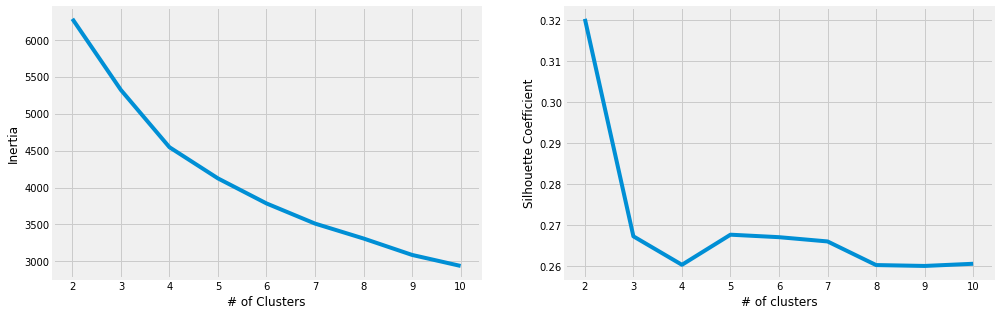

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,11)
ax1.plot(k_clusters, inertia)
ax1.set_xlabel('# of Clusters')
ax1.set_ylabel('Inertia')

ax2.plot(k_clusters, sil)
ax2.set_xlabel('# of clusters')
ax2.set_ylabel('Silhouette Coefficient')

Using both the elbow method and silhouette coefficient analysis (leaning far more on the elbow method), we estimate that the credit users may be divided optimally into four clusters. Now, let's fit the four-cluster model and assign each user to its cluster.

In [27]:
km_final = KMeans(n_clusters = 4, max_iter = 1000, random_state=1)

In [28]:
clusters = km_final.fit_predict(scaled_ccdata)

In [30]:
scaled_ccdata = pd.DataFrame(scaled_ccdata, columns = ccdata.columns[1:])

In [31]:
scaled_ccdata['CLUSTER'] = clusters + 1

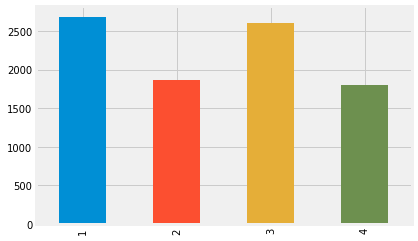

In [33]:
scaled_ccdata['CLUSTER'].value_counts(sort=False).plot(kind='bar')

The users are not fully evenly distributed amongst the four clusters, though there is no singularly small nor large cluster.

In [40]:
cluster1 = scaled_ccdata.loc[scaled_ccdata['CLUSTER'] == 1,\
                             scaled_ccdata.columns[:-1]]

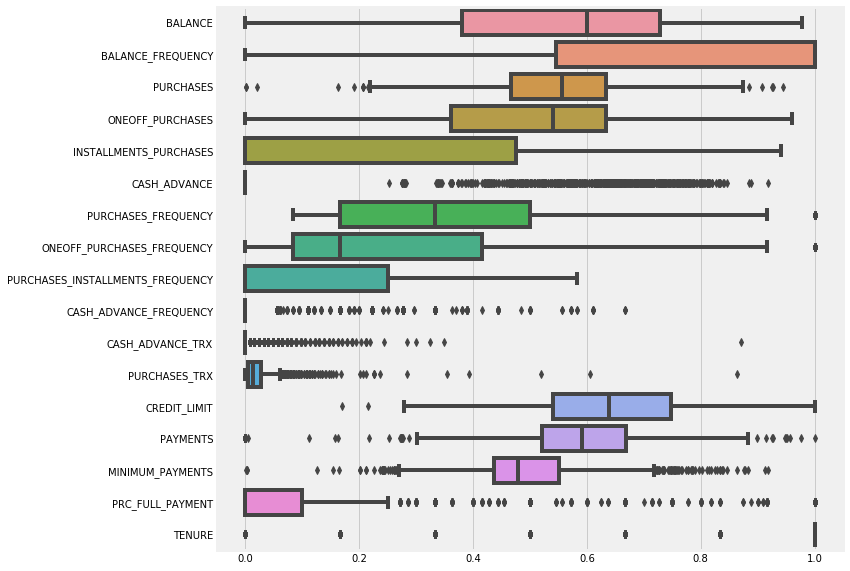

In [43]:
plt.figure(figsize=(10,10))
sns.boxplot(data=cluster1, orient='h')

The largest of the four clusters, Cluster 1 consists of users with relatively high balances, medium purchase frequencies from both types of purchases and low usage of cash advances and percentages of full payments. These users appear to be what the provider considers its most typical users who they might target the least with any kind of intervention.

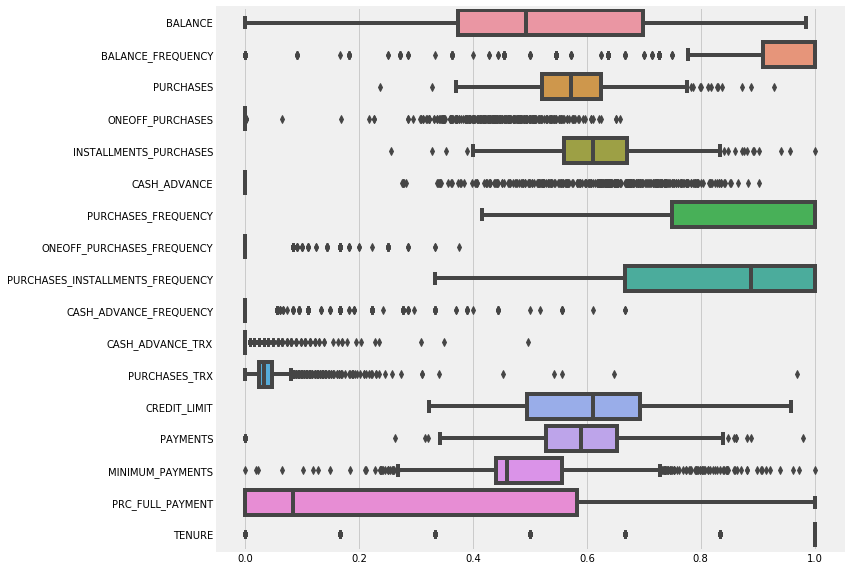

In [45]:
cluster2 = scaled_ccdata.loc[scaled_ccdata['CLUSTER'] == 2,\
                             scaled_ccdata.columns[:-1]]
plt.figure(figsize=(10,10))
sns.boxplot(data=cluster2, orient='h')

Cluster 2 consists of the 2nd fewest users, who appear to maintain the lowest balances with the lowest credit limits, along with high purchase frequency, almost entirely from installments purchases) and higher percentages of full payments made compared to users in other clusters. The card provider might seek to incentivize users in this cluster to increase one-off purchasing frequency, perhaps by increasing their generally lower credit limits.

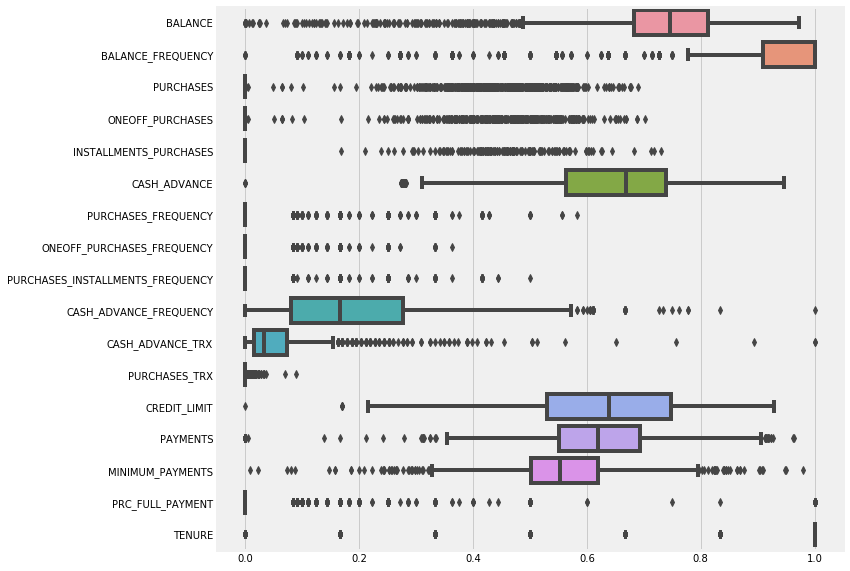

In [46]:
cluster3 = scaled_ccdata.loc[scaled_ccdata['CLUSTER'] == 3,\
                             scaled_ccdata.columns[:-1]]
plt.figure(figsize=(10,10))
sns.boxplot(data=cluster3, orient='h')

Cluster 3, featuring the second most users, generally consists of users with high balances, high cash advances, low purchasing frequency and very low percentages of full payments. The card provider may monitor and increase this group's minimum required payments more frequently than other groups.

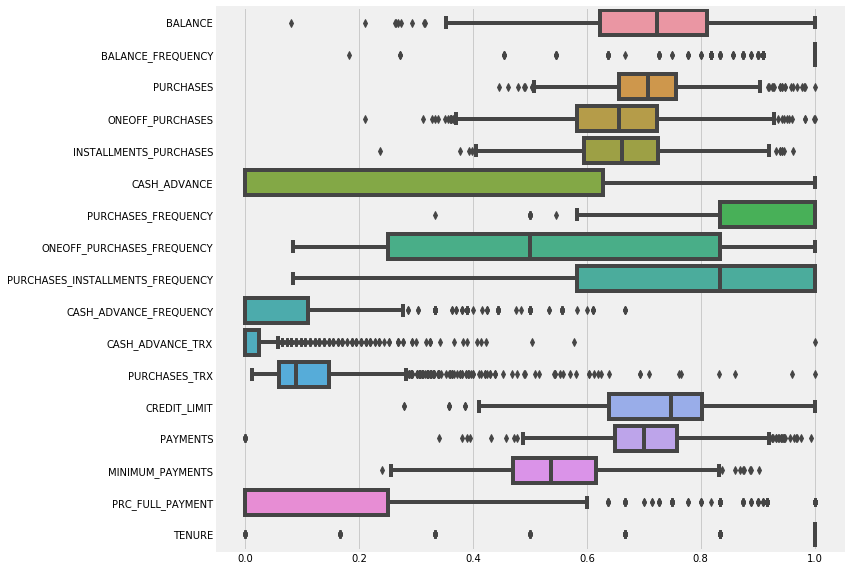

In [49]:
cluster4 = scaled_ccdata.loc[scaled_ccdata['CLUSTER'] == 4,\ 
                             scaled_ccdata.columns[:-1]]
plt.figure(figsize=(10,10))
sns.boxplot(data=cluster4, orient='h')

Cluster 4, the smallest group among the four clusters is characterized by users who maintain high balances with the highest credit lines, with high percentages of full payments (relative to users in other clusters). The card provider might be inclined to take action to encourage users in this group to continue and increase spending (perhaps through tuning of the credit limit).